In [1]:
import numpy as np
import pandas as pd
import time
import random
import os
import re
import json
import ast
import seaborn as sns
from helper_functions_assignment2 import*

## Read results from parameter tuning

In [2]:
best_configs = 'ALNS_smac_results.txt'
smac_runhistory = "ALNS_smac/96cc99e7da06dd0e30cb9e9eca2ecd4e/0/runhistory.json"

In [3]:
# read in the file with the best configurations
with open(best_configs, 'r') as file:
    file_content = file.read()

# Extract configurations using regular expressions
config_pattern = r"Configuration\(values=\{([^}]*)\}\)"
config_values = re.findall(config_pattern, file_content)

# Convert configurations to a list of dictionaries
config_dicts = []
for config_val in config_values:
    config_dict = ast.literal_eval('{' + config_val + '}')
    config_dicts.append(config_dict)

# Convert the list of dictionaries to a DataFrame
best_configs = pd.DataFrame(config_dicts)
best_configs["best_result"] = True
best_configs

,iterations_per_phase,min_weight,reaction_factor,best_result
0,146,0.182583,0.685058,True


In [4]:
# read in run history and transform to a data table
with open(smac_runhistory) as f:
    d = json.load(f)
print("SMAC3 stats:")
print(d["stats"])

# Extracting data and creating a DataFrame
data = d['data']
configs = d['configs']
config_origins = d['config_origins']


columns = ['Config_ID', 'Instance', 'Budget', 'Seed', 'Cost', 'Time', 'Status', 'Start_Time', 'End_Time', 'Additional Info']
runhistory = pd.DataFrame(data, columns=columns[:])

# Extracting score and runtime from the 'Costs' column
runhistory['score'] = runhistory['Cost'].apply(lambda x: x[0] if isinstance(x, list) and len(x) >= 1 else x)
runhistory['runtime'] = runhistory['Cost'].apply(lambda x: x[1] if isinstance(x, list) and len(x) >= 2 else None)


# Map config IDs to their configurations
runhistory['Config Info'] = runhistory['Config_ID'].map(lambda x: configs[str(x)])
runhistory['Config Origin'] = runhistory['Config_ID'].map(lambda x: config_origins[str(x)])

# Splitting Config Info into separate columns
config_info_columns = ['iterations_per_phase', 'min_weight', 'reaction_factor']
for col in config_info_columns:
    runhistory[col] = runhistory['Config Info'].apply(lambda x: x.get(col))

# make a short version for the instance name
runhistory["Instance_ID"]=runhistory["Instance"].str[4:7]
# Rearranging columns for better visibility
runhistory = runhistory[['Config_ID', 'min_weight', 'reaction_factor', 'iterations_per_phase', 
                   "Instance_ID", 
                   'Instance', 'Budget', 'Seed', 'score', "runtime", 'Time', 
                   'Status', 'Start_Time', 'End_Time']]

SMAC3 stats:
{'submitted': 80, 'finished': 80, 'running': 0}


In [5]:
# merge with best results, so we know which are the best ones
smac_results = pd.merge(runhistory, best_configs, 
                        on = config_info_columns,
                        how = "outer").fillna(False)
# bring it in a long format so we can use facet when plotting
smac_results_long = pd.melt(smac_results, id_vars=['Config_ID', "Instance_ID", "score", "runtime", "best_result"], 
        value_vars=['iterations_per_phase', 'min_weight', 'reaction_factor'])
smac_results_long

,Config_ID,Instance_ID,score,runtime,best_result,variable,value
0,1,058,11756.0,363.423423,False,iterations_per_phase,57.000000
1,1,041,51061.0,364.308560,False,iterations_per_phase,57.000000
2,1,060,36220.0,358.688440,False,iterations_per_phase,57.000000
3,2,041,51061.0,361.283585,False,iterations_per_phase,109.000000
4,2,058,11756.0,367.118007,False,iterations_per_phase,109.000000
...,...,...,...,...,...,...,...
235,26,058,11756.0,374.054324,False,reaction_factor,0.662708
236,26,060,36220.0,363.973165,False,reaction_factor,0.662708
237,27,041,51061.0,367.140472,False,reaction_factor,0.673086
238,27,060,36220.0,360.992501,False,reaction_factor,0.673086


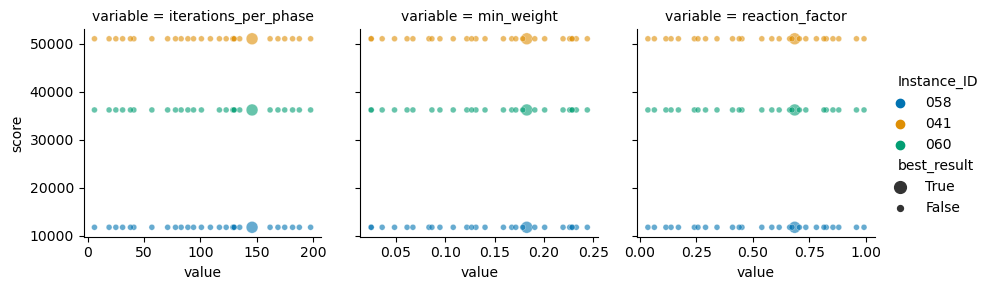

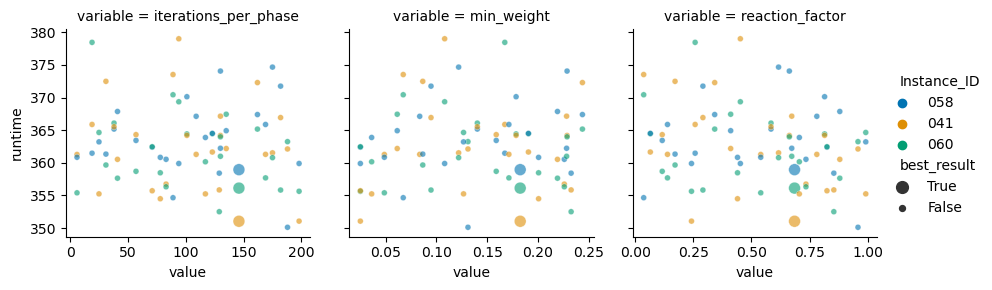

In [6]:
import warnings
warnings.filterwarnings("ignore")
# plot by score
g = sns.relplot(data=smac_results_long, x= "value", y = "score", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False),
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("ALNS_smac_score.png")

# plot by runtime
g = sns.relplot(data=smac_results_long, x= "value", y = "runtime", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False), 
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("ALNS_smac_runtime.png")

In [7]:
smac_results.loc[smac_results["iterations_per_phase"]==146]

,Config_ID,min_weight,reaction_factor,iterations_per_phase,Instance_ID,Instance,Budget,Seed,score,runtime,Time,Status,Start_Time,End_Time,best_result
17,7,0.182583,0.685058,146,041,heur041_n_300_m_17492,209652396,False,51061.0,351.032390,351.068224,1,1.705012e+09,1.705012e+09,True
18,7,0.182583,0.685058,146,060,heur060_n_300_m_12405,209652396,False,36220.0,356.116799,356.151871,1,1.705012e+09,1.705012e+09,True
19,7,0.182583,0.685058,146,058,heur058_n_300_m_4010,209652396,False,11756.0,358.942859,358.976124,1,1.705012e+09,1.705013e+09,True


# Test with best parameter settings

In [8]:
folder_path = "data/test_instances/"
problem_instances = [file.replace('.txt', '') for file in os.listdir(folder_path) if not file == "test.txt"]

In [9]:
test_results = []
iterations_per_phase = 146
for p in problem_instances:
    print(p)
    path = folder_path+p+".txt"
    node_impact_orig, node_degree_orig, plex_assignment, edges_n1, edges_n2, edge_weights, edge_assignment_orig, s, n, m = create_problem_instance(path)
    
    start = time.time()
    plex_assignment = np.random.choice(10, n)
    number_of_phases = round(4000 / iterations_per_phase)
    repair_solution(node_impact_orig, node_degree_orig, plex_assignment, edge_weights, edge_assignment_orig, s)
    
    _, _, _, _, score, traj = ALNS(0.182583, 0.685058, iterations_per_phase, number_of_phases,
        node_impact_orig, node_degree_orig, edge_assignment_orig, edge_weights, plex_assignment, s, trajectory = True)
    
    test_results.append({"Instance": p,
                         "baseline": sum(node_impact_orig)/2,
                         "score": score, 
                         "runtime": time.time()-start,
                        "trajectory": traj})
pd.DataFrame(test_results)

heur001_n_10_m_31
heur002_n_100_m_3274
heur003_n_120_m_2588
heur004_n_140_m_3014
heur005_n_160_m_4015
heur006_n_180_m_6067
heur007_n_200_m_6731
heur008_n_250_m_1045
heur009_n_250_m_1450
heur010_n_250_m_4507
heur011_n_250_m_6574
heur012_n_250_m_20035
heur013_n_250_m_22395


KeyboardInterrupt: 

In [12]:
alns_results = pd.DataFrame(test_results)
alns_results["instance_ID"] = alns_results["Instance"].str[4:7]
alns_results

,Instance,baseline,score,runtime,trajectory,instance_ID
0,heur002_n_100_m_3274,9755.0,2112.0,99.794859,"[9755.0, 9160.0, 9160.0, 9160.0, 9143.0, 9143....",002
1,heur003_n_120_m_2588,7573.0,7573.0,39.881112,"[7573.0, 7573.0, 7573.0, 7573.0, 7573.0, 7573....",003


### write results for signifficance testing

In [13]:
alns_results.to_csv("ALNS_test_results.csv", sep=';', columns=["instance_ID", "baseline", "score", "runtime"],
                  header=True, index=False)

### make some more pretty plots

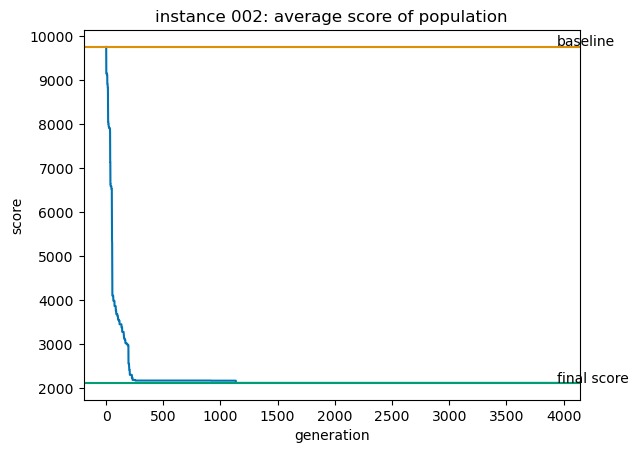

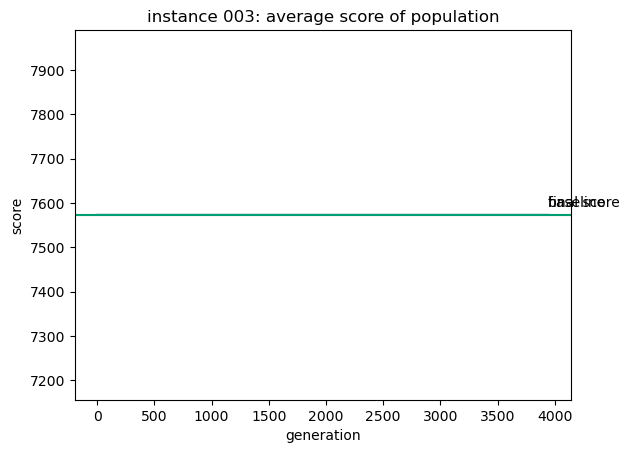

In [14]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
for inst_id in alns_results["instance_ID"]:
    baseline = alns_results["baseline"].loc[alns_results["instance_ID"]==inst_id].values[0]
    trajectory = alns_results["trajectory"].loc[alns_results["instance_ID"]==inst_id].values[0]
    final_score = alns_results["score"].loc[alns_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set(xlabel='generation', ylabel='score')
    g.set_title("instance "+inst_id+': trajectory of current score')
    
    plt.show()

### pick 2 interesting instances for the report

In [ ]:
for inst_id in ["025", "026"]:
    baseline = ga_results["baseline"].loc[ga_results["instance_ID"]==inst_id].values[0]
    trajectory = ga_results["trajectory"].loc[ga_results["instance_ID"]==inst_id].values[0]
    final_score = ga_results["score"].loc[ga_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set_title("instance "+inst_id+': average score of population')
    g.set(xlabel='generation', ylabel='score')
    #
    plt.savefig("GA_"+inst_id+".png")
    plt.show()

In [3]:
import numpy as np
import pandas as pd
import time
import sys
import random
from helper_functions_assignment2 import*

tuning_instances = ["heur040_n_300_m_13358", "heur041_n_300_m_17492", "heur042_n_300_m_5764", "heur043_n_300_m_12914",
                    "heur044_n_300_m_3234", "heur045_n_300_m_6293", "heur046_n_300_m_13150", "heur047_n_300_m_20096",
                    "heur048_n_300_m_14666", "heur052_n_300_m_26628", "heur053_n_300_m_39861", "heur054_n_300_m_2746",
                    "heur055_n_300_m_5164", "heur056_n_300_m_12131", "heur057_n_300_m_2109", "heur058_n_300_m_4010",
                    "heur059_n_300_m_7867", "heur060_n_300_m_12405"]

min_weight = 0.05 # 0.01 - 0.25
reaction_factor = 0.1 # 0.01 - 1
iterations_per_phase = 10 # 5 - 200

for instance in tuning_instances:
    path = "data/inst_tuning/" + instance +".txt"
    node_impact, node_degree, plex_assignment, edges_n1, edges_n2, edge_weights, edge_assignment, s, n, m = create_problem_instance(path)
    plex_assignment = np.random.choice(10, n)
    #repair_solution(node_impact, node_degree, plex_assignment, edge_weights, edge_assignment, s)
    number_of_phases = round(4000 / iterations_per_phase)
    
    _, _, _, _, score = ALNS(min_weight, reaction_factor, iterations_per_phase, number_of_phases, node_impact, node_degree, edge_assignment, edge_weights, plex_assignment, s)
    
    print(instance + ": " + str(score))


heur040_n_300_m_13358: 38997.0
